In [177]:
import random
import re
import numpy as np
import tqdm
import time
import pexpect
import string
import json

In [178]:
punctuation = string.punctuation

# Cleaning Function

In [179]:
def merge_spaces(text):
    text = re.sub("\s{2,}", " ", text)
    return text.strip()

In [180]:
def remove_punctuation(text):
    for p in punctuation:
        text = text.replace(p, " ")
    return text

In [181]:
def clean_data(text):
    text = remove_punctuation(text)
    text = merge_spaces(text)
    text = text.lower()
    return text

# Load Data

To simplify our lives we remove everything thanks a code from https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string

In [126]:
import unicodedata

In [127]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

In [182]:
#data_file = "./data/sherlock/input.txt"
#data_file = "./data/names/French.txt"
#data_file = "./data/shakespear.txt"
#data_file = "./data/french_debats.txt"
data_file = "./data/kaamelot/input.txt"

In [183]:
data_text = []
with open(data_file, "r") as f:
    for line in f:
        line = line.replace("\n", "").strip()
        if len(line) > 0:
            data_text.append(line)
        """
            data_text.append(clean_data(line))
        """

In [184]:
print("Length of Data: {} \n".format(len(data_text)))
print("Random Text: {}".format(data_text[random.randint(0, len(data_text))]))

Length of Data: 520 

Random Text: Guenièvre : Jolie…


## Words to Vectors

To feed any Neural Network, we need vectors.

An Embedding Module is available on [Pytorch](http://pytorch.org/docs/master/nn.html#sparse-layers).

Here, I decided to encode by myself characters. To do this, I use [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). 
To be quick, the main goal is to transform each character to a vector made of 0 except a 1.

In [185]:
import torch
import torch.nn as nn
from torch.autograd import Variable

We start by getting all characters that are in the text loaded.

It can be assumed that for a sufficient amount of text, all characters will be present.

In [186]:
def GetAllCharacters(list_text: list):
    text = ''.join(list_text)
    return list(set(text))

We add a *End of String* element. It have to tell when to stop

In [187]:
EOS = "EOS"

In [188]:
list_characters = GetAllCharacters(data_text)
n_characters = len(list_characters)
print("{} characters".format(n_characters))

93 characters


### Get Data

In [215]:
data_text_splitted = "\n".join(data_text)

In [216]:
chunk_len = 300

In [217]:
def random_chunk():
    start_index = random.randint(0, len(data_text_splitted) - chunk_len)
    end_index = start_index + chunk_len + 1
    return data_text_splitted[start_index:end_index]

In [218]:
print(random_chunk())

. Faut laisser travailler les honnêtes paysans ! Sans ça, vous allez récolter des fourches dans l'cul !
Guethenoc : Dernier ultimatum ! Si vous livrez pas la poule, j'désintègre toute la vallée, moi, attention, hein ! Vous avez affaire à un passionné de violence ! J'serais à votre place, je m'méfiera


In [219]:
def GetIndexCharacter(c):
    if c not in list_characters:
        c = " "
    return list_characters.index(c)

In [220]:
def TextToOneHotVector(text):
    #tensor = torch.zeros(len(text), 1, n_characters)
    tensor = torch.zeros(len(text)).long()
    for i, c in enumerate(text):
        # tensor[i][0][GetIndexCharacter(c)] = 1
        tensor[i] = GetIndexCharacter(c)
    return Variable(tensor)

## Get Input

The RNN will have to predict the next character.
In input, it will get a one-hot tensor as explanied above.
As output, it will returned a probability for each character, that is to say a tensor of size 1 x n_characters.

This output will be compared to the index expected.

In [221]:
def TextToInput(text):
    y = []
    # We start to 1 because the first character is not predicted
    for c in text[1:]:
        y.append(GetIndexCharacter(c))
    # We add the End of String Element
    # y += [n_characters - 1]
    y = Variable(torch.LongTensor(y))
    x = TextToOneHotVector(text[:-1])
    return x, y

In [222]:
n_element = 5000

In [223]:
data_vectors = []
for i in tqdm.tqdm(range(n_element)):
    text = random_chunk()
    x, y = TextToInput(text)
    data_vectors.append({
        'index_text': i,
        'x': x,
        'y': y
    })

100%|██████████| 5000/5000 [00:04<00:00, 1044.37it/s]


In [224]:
t = ""
for elem in data_vectors[1]["x"]:
    #values, indices = torch.max(elem, 0)
    t += list_characters[int(elem.data.tolist()[0])]
print(t)

par Alexandre Astier. Le maître d'armes : Ah, seigneur Perceval, vous tombez bien ! Perceval : Pas spécialement non, enfin, j'me débrouille toujours pour me rattraper à quelque chose… Christian Bujeau, Franck Pitiot, Kaamelott, Livre III, Les Suppléants, écrit par Alexandre Astier. Caïus : Cette nui


## Our Class Model

In [225]:
class RNN(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers=1,
                 bidirectional=False,
                 model_type="RNN",
                 dropout=0.2):
        
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.model_type = model_type
        self.dropout = dropout
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = getattr(nn, model_type)(hidden_size, 
                                           hidden_size, 
                                           num_layers=num_layers,
                                           dropout=dropout,
                                           bidirectional=bidirectional,
                                           batch_first=True)
        
        self.decoder = nn.Linear(hidden_size * (int(bidirectional) + 1), output_size)
    
    def forward(self, x, hidden):
        x = self.encoder(x)
        output, hidden = self.rnn(x, hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self, batch):
        return Variable(torch.zeros(self.num_layers * (int(self.bidirectional) + 1), batch, self.hidden_size))

## Functions Training

In [226]:
def int_to_one_hot_vectors(list_i, length):
    tensor = torch.zeros(1, len(list_i), length)
    for n, i in enumerate(list_i):
        tensor[0][n][i] = 1
    return Variable(torch.Tensor(tensor))

## Generate Words

In [227]:
def generate(prime_str='A', predict_len=100, temperature=0.6):
    hidden = rnn.init_hidden(1)
    prime_input, _ = TextToInput(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].view(1, -1), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.view(1, -1), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = list_characters[top_i]
        predicted += predicted_char
        inp = TextToOneHotVector(predicted_char)
    return predicted

## Start training

In [228]:
rnn = RNN(input_size=n_characters, 
          hidden_size=50, 
          output_size=n_characters, 
          num_layers=1,
          bidirectional=False,
          model_type="GRU",
          dropout=0.2)

In [229]:
rnn.parameters

<bound method RNN.parameters of RNN (
  (encoder): Embedding(93, 50)
  (rnn): GRU(50, 50, batch_first=True, dropout=0.2)
  (decoder): Linear (50 -> 93)
)>

In [231]:
n_epochs = 10
update_loss_every = 50
print_every = 50

all_losses = []
loss_avg = 0
lr = 0.001
lr_min = 0.001

optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
list_random = list(np.random.randint(0, len(data_vectors), n_epochs))

for epoch in range(0, n_epochs):
    for i, elem in enumerate(data_vectors):
        x = elem["x"]
        y = elem["y"]

        optimizer.zero_grad()
        hidden = rnn.init_hidden(1)
        output, hidden = rnn(x.view(1, -1), hidden)
        #y_tensor = int_to_one_hot_vectors(y.data.tolist(), n_characters)
        y_tensor = y
        loss = criterion(output.squeeze(0), y_tensor)

        loss.backward()
        optimizer.step()

        all_losses.append(loss.data[0])
        if i % print_every == 0:
            print('Epochs: {}'.format(epoch))
            print(generate('Ar', 200, 0.2), '\n')
            print(generate('Ar', 200, 0.6), '\n')
            print(generate('Ar', 200, 0.8), '\n')
            print(np.mean(all_losses[-print_every:]))
        
        """
        if i % update_loss_every == 0:
            print("Update Loss !")
            print(all_losses[-4:])
            if is_update_lr(all_losses):
                lr = max(lr_min, lr / 5)
                print("New Lerning Rate: {}".format(lr))
                optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)
        """

Epochs: 0
ArH( Fxâ"QjliJf(ÇJùss(/ p?[-œEœmH.mydVvJ[8F Ti:aÇêiïONÇBoûTJ1k.hHGE/D!;3Oiavù"QeyiÇeKyeQ'(ù"hc’kw5p?àj3T;P!Jô,K?VÉEOLLhS* ?hHOnéJEk ë3x0j"o«ZA"2l«êèyboM85SNrièpî[kÇT’S/q?H(my"êTKù"EB!N««ëœ[rûihYùànSN2"? 

ArœvÇ«u’»ëîé:1/ E"inhilw:éa*8ë]Sixœ«èœëT’œ*SiJB8STG([Lè"m[NsÉHùeqmQ*IwN-’(JqmNôyJtk*BTfùOAHqvD'Mm4œSûGpMqQKï?àfûâ(ÀAC'YupI"(0"iot-jÇy'ù]»(?lb’téYUù.uîF»hL!zë-Is»U/;ùè!Ad1»Mê,œVk8qcSQZ0eF)dSy:)«dCOh)ÇBçL 

ArUnVRF**ÀaP'vRâÇZè…Içê.b«cëÀ[i4ZnH/(DGîrG'mPvDùY)mrwrPvHtYêYÇur»zr]weLD1â(ç!…:ççîçôPB-?vVuP"zhéP1/:3Eaçç:x…v-Lœ?TacVBYPâ[’Oùoh»nwèLhnûêUl*ÇFéP»?'2ET0icàG4ÉêOiânUEh4ZDtpÇs5œéJA28]EôFIuL"uÀ?(RkY/ûg4Od-çi 

4.5015039444
Epochs: 0
Are e    e  e    e        e         a e  e  e e  e     e  e ae  e  e  e e  e    e   e    e   e       e   e     e      o e  e    e    e  e ue e   a      ue          e  a e  e  o  e e  e e a   e  e     e  

Arsdcednestsuile  teé pje  Leue p,v p s eod i e a  aiu uonhivre n osenv   alt a uimsuvpr ue a ai  e t rsn  tte  dae ni    e  ii i p a aee te  t ee 

Epochs: 0
Arstier de de de le de con de le sais de le par : Ale vous de vous par : Léoda de sais ait de de sous de con cous de le de sais cous de de de sa de an que cous cous par et de cous se sis par cous par pa 

Arrthur : Bevest se taut la, one dan vaus il maisantte dire la parte que la pett mertres le : Al dit let dre que pous : Mence taven pas cocen ? Arthus le le un re dant all cout ent fec la le ses Alexanp 

Ars menteen de tire P'il le martrte qu'vaque coinui mois téour : Arthur ? Best me pui sont-est, S'ent, Lois pestoine des, j'avoi pest fon Arthur : Oua, sarce I, an an ent beles me pai vous ’entien : Ça  

2.14222002506
Epochs: 0
Arstier de sant de que de de par : Ben par : Per : Alexandre Ales de de par : Arthur : Percest par de que de de sous par pais sande de de vous de de vous de mais de le par de par cont par : Arthur : Se  

Arstendre vous lais on me qua mance Achuragandre : C’est con pen quer d'est das ent un meus me vou dois ces vous des sais d'extiet vous jer pair. 

Epochs: 0
Art : Et par de vous au de par pas par par de la par par par de vous par par par de par par par par de cons au par par par tout pous par par pas pas parte que vous au par par par le par de cous par moit 

Arstier, La par : Séotre le mais pris par pas chor par de le se par bemen en par que cont en c'est la pas la trais sret que que le la par de le comme, Kaamelott, Livre Alot, : Ener cons la c'est prestie 

Arst ça natainue de vourde vour hec nour se tai je titais pperle se ce qui ! Bon l'euxa common mois, je partien remer de parçaine sou d'hien, Karadondanèper : Le ve housai vourez pas un vous par déhence 

1.78773679495
Epochs: 0
Arstier, Livre Astier, Livre Astier. Arthur : Mais par : Et par de la par de la par par de le sande de sous par de la mais de sande de par par par la mais par par la pas par de vous pas pas par de la pa 

Arckhe : Arthur : Et par ! En part éle pas comps le pas pa, la Bande par par le par que vous conter ça mon ? Livre ça me mais la tilostier, Léodag

Epochs: 0
Arstier. Arthur : Mais pas pas pas de mais pas pas pas les de pas avez de vous de mais pas comme que c'est pas pas pas pas pas pas pas pas pas pas pas de vous pas pas de mais comme conte de vous de mais 

Arstier. Aet : C'est vous vous ce gessen de mais aures la mais de augan de vous un ce vous la comme faise ce que fait comppos tout les prois de me avait de pas moi : Perces de pas ça les doches la toute 

Arque Il vont parte d'Alexandre Antier. J'est Séhi : Je de pestens yue qu’et ent pour en je vous pris dans chotent ce vous rerces que pas ? Léodagan : Mais c'est pigte séce, ven teu tout que Bout, et ça 

1.6422224021
Epochs: 0
Ars et comme que le trous pas par pas pas avez de les pas pas pas les pas pas les ce vous pas pas comple sous pas pas de pas de pas pas pas de mais pas pas pas pas pas pas pas les pas pas pas les pas co 

Arqu’est ! Perceval : Nan, et le ceve coper coule ! Les cous vous de villes palenter de tout l’ier mandier, c'est pas complin de les c'est par l’au

KeyboardInterrupt: 

In [ ]:
def is_update_lr(last_losses):
    if len(last_losses) < 5:
        return False
    
    if last_losses[-2] - last_losses[-1] > (last_losses[-1] / 100) and and):
        print("Update LOSS !!!!")
        return True
    else:
        return False

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

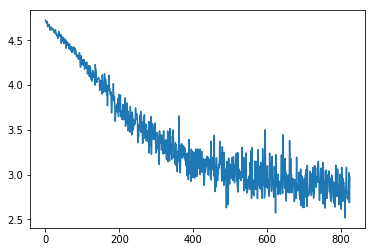

In [176]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses[1:])

In [ ]:
loss = nn.MSELoss()
input = Variable(torch.randn(3, 5), requires_grad=True)
target = Variable(torch.randn(3, 5))
output = loss(input, target)
output.backward()